### Clouds : Ana nodes (diferential laplacian) from clouds with NEXT MC Beersheba events

J. A Hernando, M. Pérez

January 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds

import clouds.mc_clouds as mcclouds

import invisible_cities.io.dst_io as dio

In [4]:
from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits

In [5]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu Jan 20 18:19:46 2022


In [6]:
#import os
import re
import glob

In [7]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/"
filenames = ("Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5", 
             "Tl208_NEW_v1_03_01_nexus_v5_03_04_cut25.beersheba_label_4mm_fid.h5")
filenames = [datadir+file for file in filenames]
print('total files', len(filenames))
print(filenames[0])

total files 2
/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5


In [8]:
def get_dfs(filename):
    
    dfs = {}
    
    dfs['rcvoxels'] = dio.load_dst(filename, 'DATASET', 'BeershebaVoxels')
    dfs['mcvoxels'] = dio.load_dst(filename, 'DATASET', 'MCVoxels')
    dfs['mchits']   = dio.load_dst(filename, 'DATASET', 'MCHits')
    dfs['events']   = dio.load_dst(filename, 'DATASET', 'EventsInfo')
    dfs['bins']     = dio.load_dst(filename, 'DATASET', 'BinsInfo')
    
    return dfs

In [9]:
dfs = get_dfs(filenames[0])

In [10]:
rcvoxels   = dfs['rcvoxels']
mchits     = dfs['mchits']
voxel_size = [float(dfs['bins'][var].unique()) for var in ('size_x', 'size_y', 'size_z')]
print(voxel_size)

[5.0, 5.0, 4.0]


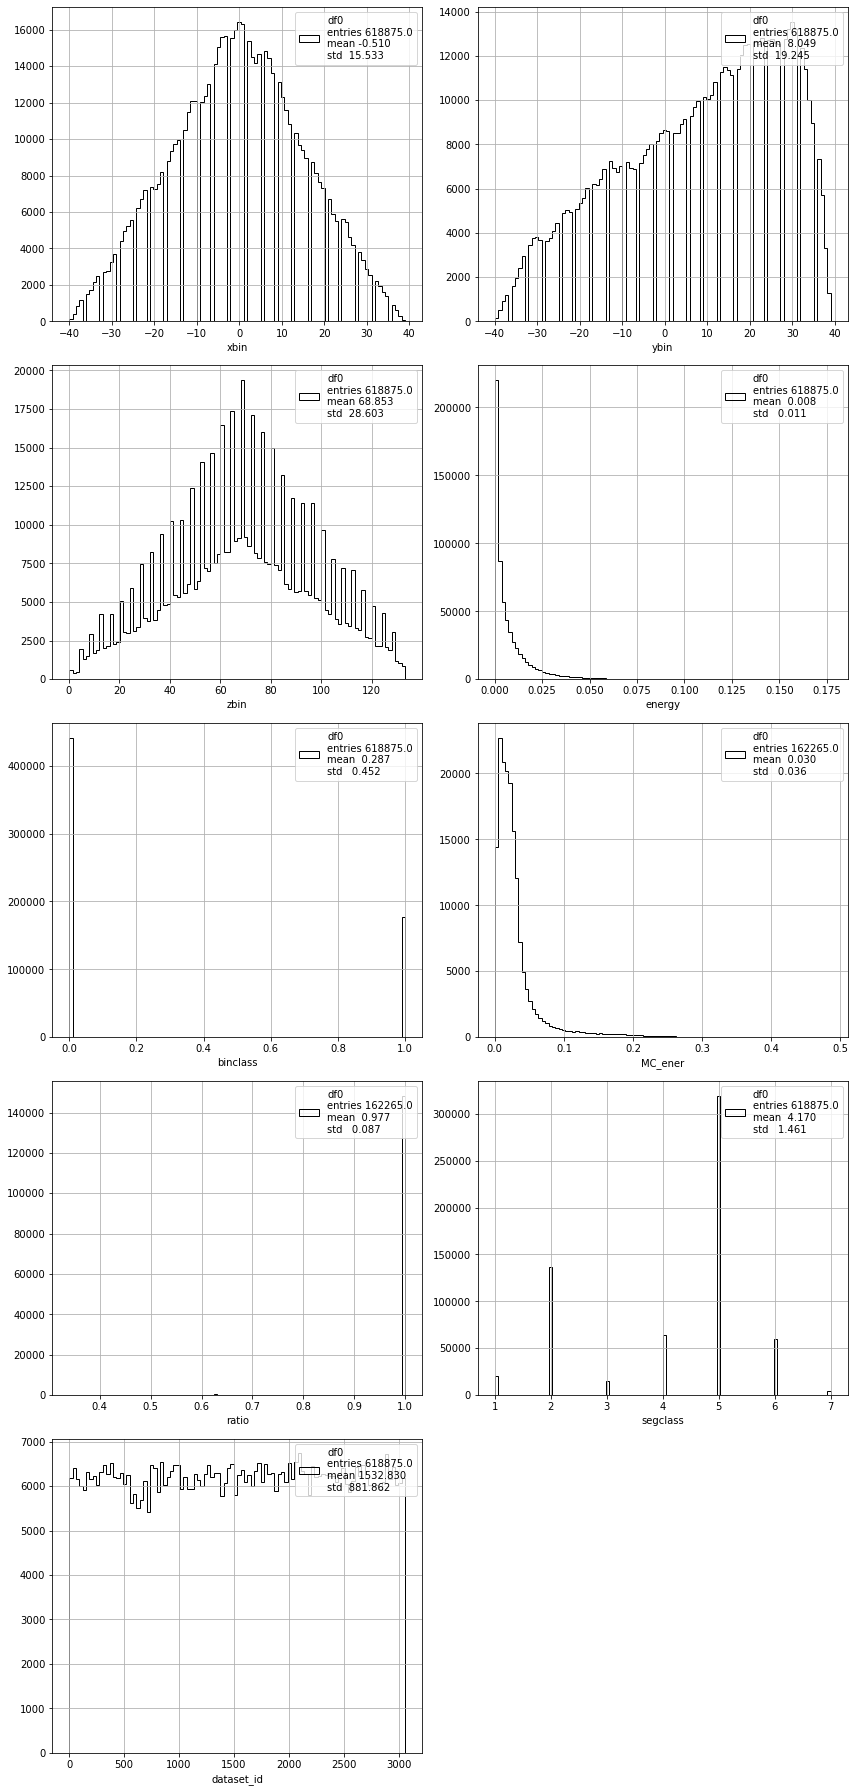

In [11]:
pltext.df_inspect(rcvoxels)

## Run: 

make clouds
ana nodes, are blobs? compute properties of nodes
return df


In [37]:
### Run over the events in the file
def run(rcvoxels, voxel_size, nevents = -1):

    seg_blob = 3
    
    varname = 'lap'
    
    events = rcvoxels['dataset_id'].unique()
    df     = None 
    nevents = len(events) if nevents == -1 else nevents
    print('events to process ', nevents)
    for evt in events[:nevents]:
        
        evoxels    = rcvoxels[rcvoxels.dataset_id == evt]
        ehits      = mchits  [mchits  .dataset_id == evt]
        edataclass = int(evoxels.binclass.unique())
        if (evt%100 == 0):
            print('Event :', evt, ', class : ', edataclass)
    
        coors  = [evoxels[var].values for var in ('xbin', 'ybin', 'zbin')]
        coors  = [size * coor for size, coor in zip(voxel_size, coors)]
        ene    = evoxels['energy'].values
        bins, mask, cells, cloud = clouds.clouds(coors, voxel_size, ene)
        cloud['segclass'] = evoxels['segclass'].values
    
        sel = cloud['segclass'] == seg_blob
        blob_nodes      = cloud['enode'][sel].unique()
        blob_cell_nodes = (cloud['eisnode'] == True) & (cloud['segclass'] == seg_blob)
        #print('blob nodes ', blob_nodes)
        #print('blob nodes cell ', np.sum(blob_cell_nodes), cloud['kid'][blob_cell_nodes].values)

        # create a DF with the nodes information
        nodes         = cloud['enode'].unique()
        nodes_seg     = np.array([int(cloud['segclass'][node]) for node in nodes])
        nodes_isblob  = np.isin(nodes, blob_nodes)
        nodes_size    = np.array([np.sum(cloud['enode'] == node) for node in nodes])
        nodes_energy  = np.array([np.sum(cloud[cloud['enode'] == node][varname]) for node in nodes])
        nodes_enecell = np.array([float(cloud[varname][node]) for node in nodes])

        def blob_order(vals, nodes):
            sig = -1 if (varname == 'lap') else 1
            vals, pos = clouds.ut_sort(sig * vals, nodes)
            ipos = [int(np.where(pos == node)[0]) for node in nodes]
            return ipos 

        nodes_osize    = blob_order(nodes_size   , nodes)
        nodes_oenergy  = blob_order(nodes_energy , nodes)
        nodes_oenecell = blob_order(nodes_enecell, nodes)

        nnodes  = len(nodes)
        dfnodes = pd.DataFrame()
        dfnodes['dataset_id'] = np.ones(nnodes, int) * evt
        dfnodes['dataclass']  = np.ones(nnodes, int) * edataclass
        dfnodes['blobs']      = np.ones(nnodes, int) * len(blob_nodes)
        dfnodes['nodes']     = np.arange(nnodes)
        dfnodes['segclass']  = nodes_seg
        dfnodes['isblob']    = nodes_isblob
        dfnodes['size']      = nodes_size
        dfnodes[varname]    = nodes_energy 
        dfnodes[varname + 'cell']   = nodes_enecell
        dfnodes['osize']     = nodes_osize
        dfnodes['o'+varname]   = nodes_oenergy 
        dfnodes['o'+varname+'cell']  = nodes_oenecell

        #print(dfnodes)
        
        df = dfnodes if df is None else pd.concat((df, dfnodes), ignore_index = True)
    
    return df

In [59]:
df = run(rcvoxels, voxel_size, -1)

events to process  3059
Event : 0 , class :  0
Event : 100 , class :  1
Event : 200 , class :  0
Event : 300 , class :  0
Event : 400 , class :  0
Event : 500 , class :  1
Event : 600 , class :  1
Event : 700 , class :  0
Event : 800 , class :  0
Event : 900 , class :  0
Event : 1000 , class :  1
Event : 1100 , class :  0
Event : 1200 , class :  0
Event : 1300 , class :  0
Event : 1400 , class :  0
Event : 1500 , class :  0
Event : 1600 , class :  1
Event : 1700 , class :  1
Event : 1800 , class :  0
Event : 1900 , class :  0
Event : 2000 , class :  1
Event : 2100 , class :  0
Event : 2200 , class :  1
Event : 2300 , class :  0
Event : 2400 , class :  0
Event : 2500 , class :  0
Event : 2600 , class :  0
Event : 2700 , class :  1
Event : 2800 , class :  0
Event : 2900 , class :  0
Event : 3000 , class :  1


In [60]:
df

,dataset_id,dataclass,blobs,nodes,segclass,isblob,size,lap,lapcell,osize,olap,olapcell
0,0,0,1,0,7,False,4,-0.000099,-0.000027,1,7,7
1,0,0,1,1,3,True,32,-0.033708,-0.005008,5,0,0
2,0,0,1,2,7,False,1,-0.000024,-0.000024,0,8,8
3,0,0,1,3,1,False,24,-0.005912,-0.002070,3,6,3
4,0,0,1,4,2,False,19,-0.008657,-0.001956,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
26150,3058,0,1,7,2,False,20,-0.005594,-0.000863,6,4,7
26151,3058,0,1,8,2,False,14,-0.004084,-0.001335,4,6,4
26152,3058,0,1,9,7,False,1,-0.000033,-0.000033,0,10,11
26153,3058,0,1,10,1,False,11,-0.000818,-0.000256,2,8,8


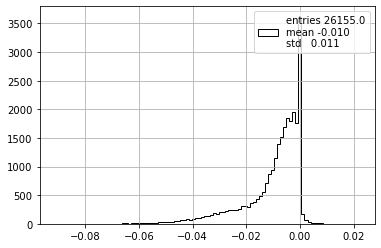

In [61]:
pltext.hist(df['lap'], 100);

1670 13152
order lap [83.17307692 12.43990385  2.52403846  0.78125     0.30048077  0.18028846
  0.12019231  0.12019231  0.12019231  0.24038462]
order energy cell  [7.68263473e+01 1.75449102e+01 3.77245509e+00 8.38323353e-01
 7.18562874e-01 5.98802395e-02 1.19760479e-01 0.00000000e+00
 5.98802395e-02 5.98802395e-02]


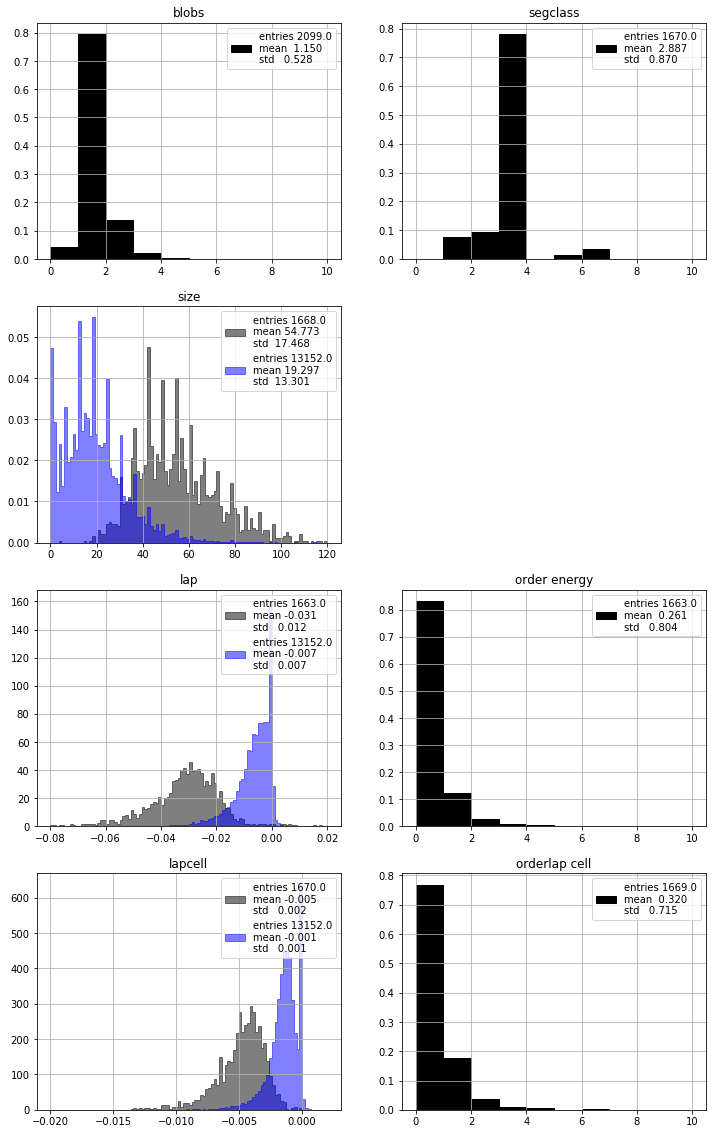

In [62]:
varname = 'lap'

xsel = (df.dataclass == 0) & (df.isblob == True)  & (df.blobs == 1)
ysel = (df.dataclass == 0) & (df.isblob == False) & (df.blobs == 1)
print(np.sum(xsel), np.sum(ysel)); 
cd = pltext.canvas(7, 2)
cd(1); plt.title('blobs')
pltext.hist(df['blobs'][(df.dataclass == 0) & (df.osize == 0)], 10, (0, 10), density = True, fill = True);
cd(2); plt.title('segclass')
pltext.hist(df['segclass'][xsel], 10, (0, 10), density = True, fill = True); 

cd(3); plt.title('size');
pltext.hist(df['size'][xsel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
pltext.hist(df['size'][ysel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
#cd(4); plt.title('order size');
#pltext.hist(df['osize'][xsel], 10, (0, 10), density = True, fill = True);
#counts, _  = np.histogram(df['osize'][xsel], 10, (0, 10), density = True)
#print('order size ', 100*counts)

cd(5); plt.title(varname);
pltext.hist(df[varname][xsel], 100, (-0.08, 0.02), density = True, fill = True, alpha = 0.5);
pltext.hist(df[varname][ysel], 100, (-0.08, 0.02), density = True, fill = True, alpha = 0.5);
cd(6); plt.title('order energy');
pltext.hist(df['o'+varname][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['o'+varname][xsel], 10, (0, 10), density = True)
print('order '+varname, 100*counts)

cd(7); plt.title(varname+'cell');
pltext.hist(df[varname+'cell'][xsel], 100, (-0.02, 0.002), density = True, fill = True, alpha = 0.5);
pltext.hist(df[varname+'cell'][ysel], 100, (-0.02, 0.002), density = True, fill = True, alpha = 0.5);
cd(8); plt.title('order'+varname+' cell');
pltext.hist(df['o'+varname+'cell'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['o'+varname+'cell'][xsel], 10, (0, 10), density = True)
print('order energy cell ', 100*counts)


1126 2723
order lap [46.875      39.64285714  8.57142857  2.41071429  0.98214286  0.44642857
  0.71428571  0.08928571  0.26785714  0.        ]
order energy cell  [43.51687389 38.01065719 12.25577265  4.08525755  1.42095915  0.17761989
  0.17761989  0.17761989  0.17761989  0.        ]


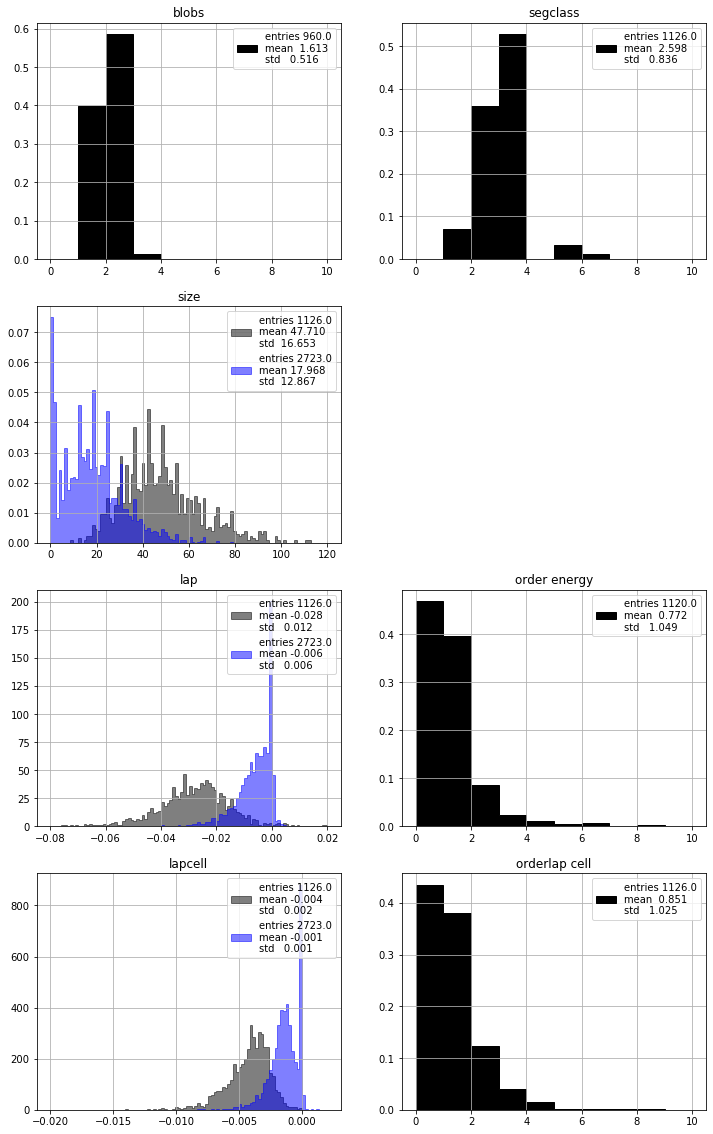

In [63]:
varname = 'lap'

xsel = (df.dataclass == 1) & (df.isblob == True)  & (df.blobs == 2)
ysel = (df.dataclass == 1) & (df.isblob == False) & (df.blobs == 2)
print(np.sum(xsel), np.sum(ysel)); 
cd = pltext.canvas(7, 2)
cd(1); plt.title('blobs')
pltext.hist(df['blobs'][(df.dataclass == 1) & (df.osize == 0)], 10, (0, 10), density = True, fill = True);
cd(2); plt.title('segclass')
pltext.hist(df['segclass'][xsel], 10, (0, 10), density = True, fill = True); 

cd(3); plt.title('size');
pltext.hist(df['size'][xsel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
pltext.hist(df['size'][ysel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
#cd(4); plt.title('order size');
#pltext.hist(df['osize'][xsel], 10, (0, 10), density = True, fill = True);
#counts, _  = np.histogram(df['osize'][xsel], 10, (0, 10), density = True)
#print('order size ', 100*counts)

cd(5); plt.title(varname);
pltext.hist(df[varname][xsel], 100, (-0.08, 0.02), density = True, fill = True, alpha = 0.5);
pltext.hist(df[varname][ysel], 100, (-0.08, 0.02), density = True, fill = True, alpha = 0.5);
cd(6); plt.title('order energy');
pltext.hist(df['o'+varname][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['o'+varname][xsel], 10, (0, 10), density = True)
print('order '+varname, 100*counts)

cd(7); plt.title(varname+'cell');
pltext.hist(df[varname+'cell'][xsel], 100, (-0.02, 0.002), density = True, fill = True, alpha = 0.5);
pltext.hist(df[varname+'cell'][ysel], 100, (-0.02, 0.002), density = True, fill = True, alpha = 0.5);
cd(8); plt.title('order'+varname+' cell');
pltext.hist(df['o'+varname+'cell'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['o'+varname+'cell'][xsel], 10, (0, 10), density = True)
print('order energy cell ', 100*counts)

## Conclusions

 * Why there are electrons events with no-blobs? => problem with electrons from by photo-electric 
 
 * Why there are 2 electrons events with 1 blob?
 
 * What are the electron events with > 1 blob? => second electron with few energy, modify labeling of blobs!
 
 * What are the 2 electrons events with > 2 blobs?
 
 * For the good electrons events (blob == electron): 83%(95.5%) of the cases the blob in in the most (two most) energetic nodes
 
 * For the good 2 electrons events (blobs == electrons): 86%(94%) of the cases the 2 blobs are the 2(3) most energetic.
 
 Very similar to the energy!!